In [3]:
%matplotlib inline

In [4]:
import os
import numpy as np
import glob
import geopandas as gpd
from shapely.geometry import Point, LineString, Polygon, shape, mapping
import pandas as pd
import xarray as xr
import shapely.geometry as geometry
from geopandas import GeoDataFrame, GeoSeries
import time
import math

C:\Users\sandyjones\.conda\envs\geo\lib\site-packages\xarray\core\merge.py:10: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


## Making Mask Layer Polygons

In [5]:
def resample(mask, resample_ratio):
    if resample_ratio==1:
        return mask
    rows = mask.shape[0]
    cols = mask.shape[1]
    pad_rows = math.ceil(rows/resample_ratio)*resample_ratio - rows
    pad_cols = math.ceil(cols/resample_ratio)*resample_ratio - cols
    
    padded_mask = np.pad(mask, ((0, pad_rows), (0, pad_cols)), mode='edge')
    resample_mask = padded_mask.reshape((rows+pad_rows)//resample_ratio, resample_ratio, (cols+pad_cols)//resample_ratio, resample_ratio)
    resample_mask = np.rollaxis(resample_mask, 1, 3)
    resample_mask = resample_mask.reshape((resample_mask.shape[0], resample_mask.shape[1], -1))
    resample_mask = resample_mask.max(-1)
    return resample_mask

In [22]:
def extract_cloud_mask(ncfile, resample_ratio=1):
    DS = xr.open_dataset(ncfile)
    _mask = (DS['CHL_OC4ME']>254.9)
    mask = np.copy(_mask)
    
    # Pad
    resample_mask = resample(mask, resample_ratio)
    padded_mask_rows = resample_mask.shape[0]*resample_ratio
    padded_mask_cols = resample_mask.shape[1]*resample_ratio
    
    # LatLons
    lats = np.pad(np.copy(DS.lat), (0, padded_mask_rows-mask.shape[0]), mode='edge').reshape(-1, resample_ratio).mean(-1)
    lats = np.repeat(lats, resample_mask.shape[1])
    lons = np.pad(np.copy(DS.lon), (0, padded_mask_cols-mask.shape[1]), mode='edge').reshape(-1, resample_ratio).mean(-1)
    lons = np.repeat(lons, resample_mask.shape[0]).reshape(resample_mask.T.shape).T.reshape(-1)
    indices = np.argwhere(resample_mask.reshape(-1))
    x = np.concatenate([lats[indices], lons[indices]], -1)
    
    # Cell Size
    cell_size_y = abs(lats[0].item() - lats[1].item())
    cell_size_x = abs(lons[1].item() - lons[0].item())
    av_cell_size = (cell_size_y + cell_size_x)/2
    
    # Pixel Extents
    y_min = x[:, 0] - (av_cell_size*3)/2
    y_max = x[:, 0] + (av_cell_size*3)/2
    x_min = x[:, 1]-(av_cell_size*3)/2
    x_max = x[:, 1]+(av_cell_size*3)/2
    cols = indices // resample_mask.shape[1]
    
    # Make Polygons
    start = time.time()
    poly_store = []
    i = 0
    while i < x.shape[0]:
        if i % 100 == 0:
            progress= i/x.shape[0]
            elapsed= time.time()-start
            eta = ((elapsed)/(i+1))*(x.shape[0]-i)
            message = f"Progres:{(progress*100):.2f} % | eta:{eta:.2f}s | elapsed:{elapsed:.2f}s"
            print(message, end='\r')
        #
        _x_min = x_min[i]
        _y_min = y_min[i]
        ri = i+1
        while ri < x.shape[0] and indices[i]+1 == indices[ri] and cols[i] == cols[ri]:
            i=i+1
            ri=ri+1
        _x_max = x_max[i]
        _y_max = y_max[i]
        #
        p = Polygon([(_x_min, _y_min), (_x_min, _y_max), (_x_max, _y_max),(_x_max, _y_min), (_x_min, _y_min)])
        poly_store.append(p)
        i+=1
    elapsed= time.time()-start
    message = f"Progres: 100 % | eta:0.0s | elapsed:{elapsed:.2f}s        "
    print(message)
    
    # DataFrame
    df = GeoDataFrame(geometry=GeoSeries(poly_store), crs={"init":"EPSG:4326"})
    df['a'] = df.index//100
    dissolved_df = df.dissolve(by='a').reset_index(drop=True)
    return dissolved_df

In [23]:
ncfile = "S3A_OL_2_WFR____20200502T054952_20200502T055252_20200503T144640_0179_057_376_2520_MAR_O_NT_002_SEN3.nc"

## Resample Ratio 3

In [24]:
resample_ratio = 3 # rr**2 guna kam karta hai points aur resolution ko

In [25]:
%time df = extract_cloud_mask(ncfile=ncfile, resample_ratio=resample_ratio)

Progres:100 % | eta:0.0s | elapsed:7.53s        
Wall time: 11.9 s


In [27]:
len(df)

400

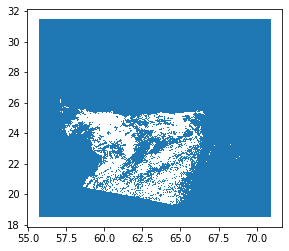

In [26]:
df.plot()

## Resample Ratio 2

In [28]:
resample_ratio = 2 # rr**2 guna kam karta hai points aur resolution ko

In [29]:
%time df = extract_cloud_mask(ncfile=ncfile, resample_ratio=resample_ratio)

Progres:100 % | eta:0.0s | elapsed:16.33s        
Wall time: 22.7 s


In [30]:
len(df)

881

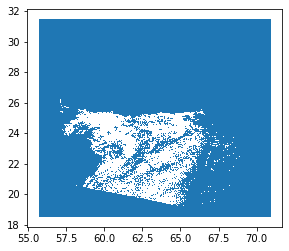

In [31]:
df.plot()

## Resample Ratio 1

In [36]:
resample_ratio = 1 # rr**2 guna kam karta hai points aur resolution ko

In [37]:
%time df = extract_cloud_mask(ncfile=ncfile, resample_ratio=resample_ratio)

Progres:100 % | eta:0.0s | elapsed:63.56s        
Wall time: 1min 22s


In [38]:
len(df)

4546

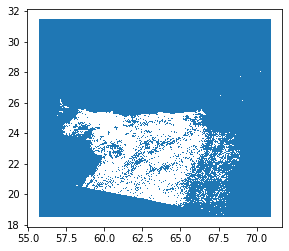

In [39]:
df.plot()